# 04: Evaluation

This Jupyter Notebook shows an evaluation of multiple synthetic dataset generated using different type of Generative Adversarial Networks (GANs). We compare the synthetic dataset with the original [WESAD](https://ubicomp.eti.uni-siegen.de/home/datasets/icmi18/) dataset it is based on. The evaluation is performed using different quality assesment options in terms of synthetic data based on the work of [Ehrhart et al.](https://www.mdpi.com/1424-8220/22/16/5969)

EVALUATION: QUALITY ASSESSMENT OPTIONS

1. Diversity (Visual Evaluation):
    samples should be as distributed as the real data points
Visualization by t-SNE und PCA

2. Fidelity (Statistical Evaluation):
samples should be indistinguishable from real points
Quantitative measure of equality
Train a binary classifier that distinguishes real data points from generated data points. Original sequence is labeled as real; any generated sequence is labeled as not real.
3. Usefulness (TSTR): evaluate how well the generated data preserves the predictive characteristics of the original
Train on synthetic, test on real (TSTR) framework

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from metric.visualization import visualization

from synthesizers.preprocessing.wesad import Subject, WESADDataset
from synthesizers.utils.training import data_split, buildDataCTST, generate_and_plot_data, synthetic_dataset

In [2]:
SIGTOI = {"BVP": 0, "EDA": 1, "ACC_x": 2, "ACC_y": 3, "ACC_z": 4, "TEMP": 5}
ITOSIG = {0: 'BVP', 1: 'EDA', 2: 'ACC_x', 3: 'ACC_y', 4: 'ACC_z', 5: 'TEMP'}
DATA_PATH = 'data/wesad/wesad_preprocessed_1hz.csv'
SAMPLING_RATE = 1


In [3]:
df = pd.read_csv(DATA_PATH, index_col=0)
df_label = df['label']
df_stress = df[df['label']==1]
df_no_stress = df[df['label']==0]

trainX, label_trainX = WESADDataset.create_windows(df, 1)
mos, _ = WESADDataset.create_windows(df_stress, SAMPLING_RATE)
non_mos, _ = WESADDataset.create_windows(df_no_stress,SAMPLING_RATE)

num_split = 0.8
trainmos, testmos = data_split(mos, num_split)
trainnomos, testnomos = data_split(non_mos, num_split)

syn_data = np.load("data/syn/cond_syn_gen_5400.npy")
# syn_data = np.load("data/syn/cgan/dp/5400.npy")
dp_syn_data = np.load("data/syn/cgan/no_dp/5400.npy")
syn_no_stress = syn_data[:len(syn_data)//2, :, :]
syn_stress = syn_data[len(syn_data)//2:, :, :]

/Users/nils/thesis/Data_Generation/synthesizers/preprocessing/wesad.py:126: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  get_max_value_from_list(df["label"][i : i + window_len].to_list())


### 1. Diversity

- Assessing the diversity and distribution of synthetic data is crucial in its evaluation.
- Principal Component Analysis (PCA) and t-Distributed Stochastic Neighbor Embedding (t-SNE) are employed for visual evaluation.
- PCA reduces dimensionality while preserving significant variance, enabling comparison of synthetic and real data distributions through plots.
- t-SNE reveals local structures and patterns, generating plots that highlight similarities and differences between synthetic and real datasets.
- Successful synthetic data generation should exhibit well-distributed points mixed among the clusters of the original data, indicating satisfactory diversity preservation.

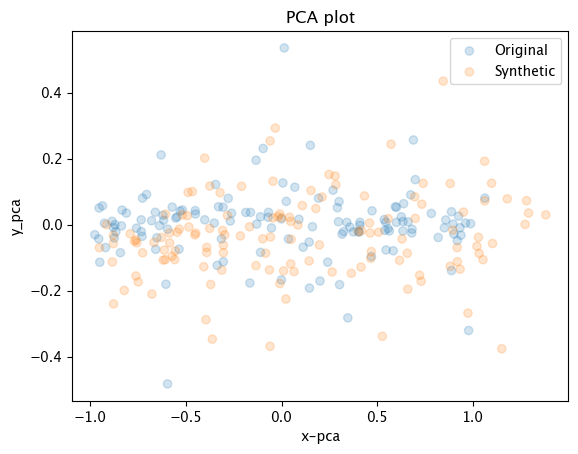

In [4]:
visualization(trainmos[:len(syn_stress)], syn_stress, "pca")

/Users/nils/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/nils/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 264 samples in 0.000s...
[t-SNE] Computed neighbors for 264 samples in 0.029s...
[t-SNE] Computed conditional probabilities for sample 264 / 264
[t-SNE] Mean sigma: 0.172300
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.580864
[t-SNE] KL divergence after 300 iterations: 0.254312


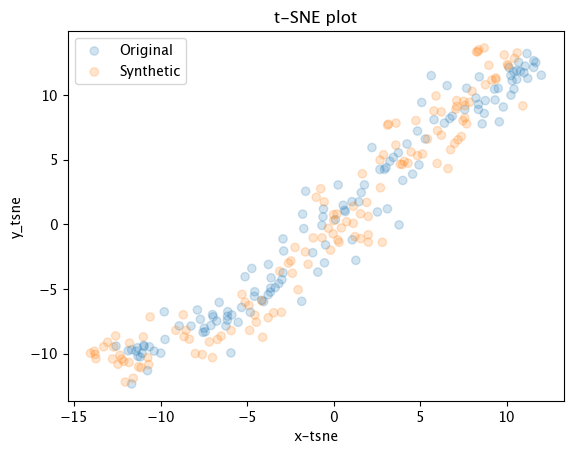

In [5]:
visualization(trainmos[:len(syn_stress)], syn_stress, "tsne")

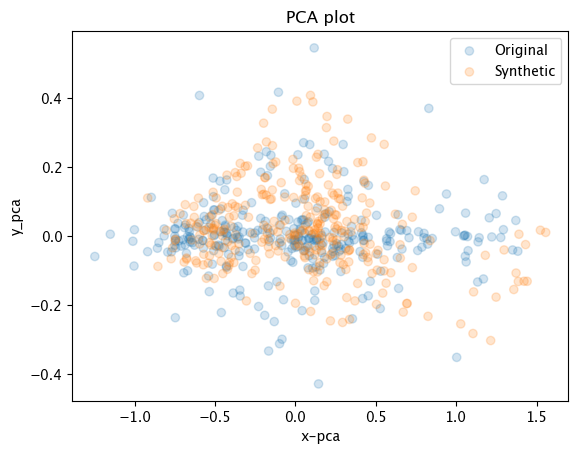

In [6]:
visualization(trainnomos[:len(syn_no_stress)], syn_no_stress, "pca")

Comparison of t-SNE plot between synthetic stress moments and original non-stress moments

/Users/nils/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/nils/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 616 samples in 0.000s...
[t-SNE] Computed neighbors for 616 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 616 / 616
[t-SNE] Mean sigma: 0.119712
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.760876
[t-SNE] KL divergence after 300 iterations: 0.456847


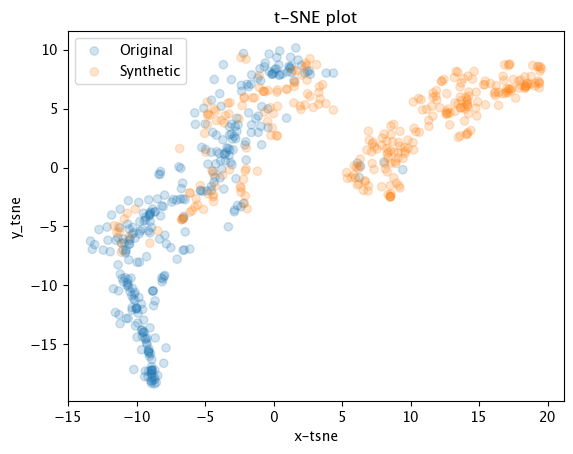

In [7]:
visualization(trainnomos[:len(syn_stress)], syn_stress, "tsne")

### 2. Fidelity

- Fidelity assessment aims to determine the extent to which the generated synthetic data closely resembles the statistical characteristics of the real data.
- High fidelity indicates that the generated data exhibits similar distributional properties, correlation structures, and higher-order statistical features as the original data, making it challenging to distinguish between them.
- This statistical evaluation provides a quantitative measure of how well the synthetic data aligns with the real data in terms of their underlying distributions and statistical properties.
- To enhance the evaluation of fidelity, a two-sample hypothesis test can be conducted to assess the statistical significance of any observed differences between the synthetic and real datasets.
- The two-sample test helps quantify the level of similarity between the datasets and provides additional evidence supporting the fidelity assessment.

### Statistical Distribution

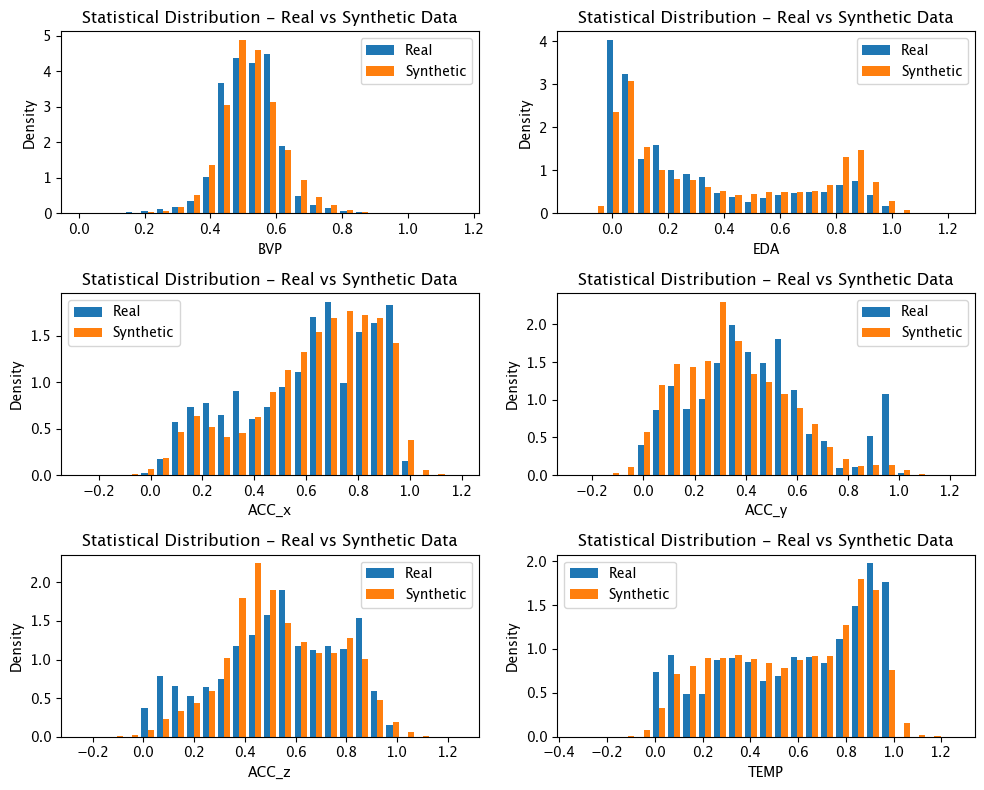

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 2, figsize=(10, 8))

# Compare distribution of T_out values
for sig_num, ax in zip(range(len(SIGTOI)), axs.flatten()):
    ax.hist([trainX[:, :, sig_num].flatten(), syn_data[:, :, sig_num].flatten()], 
            label=["Real", "Synthetic"],
            bins=25,
            density=True)
    ax.legend()
    ax.set_xlabel(ITOSIG[sig_num])
    ax.set_ylabel("Density")
    ax.set_title("Statistical Distribution - Real vs Synthetic Data")

plt.tight_layout()
plt.show()


### Two-sample hypothesis testing 

In [9]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

dataset1 = trainmos
dataset2 = syn_stress[:len(trainmos)]
sample_num = 100
indistinguishable_count = 0

for i in range(sample_num):

    # Randomly select one index
    indice = np.random.choice(np.arange(len(dataset1)))

    # Extract the corresponding samples
    sample_dataset1 = dataset1[indice]
    sample_dataset2 = dataset2[indice]

    # Perform the two-sample t-test
    t_statistic, p_value = stats.ttest_ind(sample_dataset1, sample_dataset2)

    # Print the results
    # print("P-Value: ", p_value)

    # Check if the p-value is greater than the significance level
    alpha = 0.05  # Set the significance level
    if p_value.all() > alpha:
        print("The samples are indistinguishable based on the p-value.")
        indistinguishable_count += 1
    else:
        print("The samples are distinguishable based on the p-value.")

print()
print(f"{indistinguishable_count} of {sample_num} are indistinguishable")

The samples are indistinguishable based on the p-value.
The samples are indistinguishable based on the p-value.
The samples are indistinguishable based on the p-value.
The samples are indistinguishable based on the p-value.
The samples are indistinguishable based on the p-value.
The samples are indistinguishable based on the p-value.
The samples are indistinguishable based on the p-value.
The samples are indistinguishable based on the p-value.
The samples are indistinguishable based on the p-value.
The samples are indistinguishable based on the p-value.
The samples are indistinguishable based on the p-value.
The samples are indistinguishable based on the p-value.
The samples are indistinguishable based on the p-value.
The samples are indistinguishable based on the p-value.
The samples are indistinguishable based on the p-value.
The samples are indistinguishable based on the p-value.
The samples are indistinguishable based on the p-value.
The samples are indistinguishable based on the p

/var/folders/3k/sjklqbj91hg9fgb_kbwpy1p40000gn/T/ipykernel_96837/3106264363.py:20: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_statistic, p_value = stats.ttest_ind(sample_dataset1, sample_dataset2)


### 3. Usefulness—evaluate how well the generated data preserves the predictive characteristics of the original
Train on synthetic, test on real (TSTR) framework